# 眾量級Andy指控影片後續討論分析
- Group1：<br>&emsp;M134020033	吳承穎、M134020013	梁瑋旂、M134020036	謝昕叡、M134020051	柯昆霖、B104020002	劉和媛、B104020006	莊子儀、B114020039	莊尹安<p>
- 專案動機<br>&emsp;眾量級Andy指控影片後續討論分析，希望可以了解大眾在觀看完Andy的指控影片後，對於家寧和Andy的個別看法與討論。<p>
- 程式碼或TARFlow流程說明
    1. 使用TARFlow抓取2025/3/1至2025/3/20的相關資料。
    2. 分別找出提及家寧或Andy的文章，並排除新聞報導。
    3. 分析每日雙方的正負面情緒文章狀況。
    4. 繪製文字雲，更詳細地探索針對兩人的討論主題。<p>
- 遇到的困難和解決方式
    1. 討論家寧與Andy的文章高度重疊，區分困難。<br>在對文章進行分類後，進一步尋找提及特定關鍵字實體的文句進行分析。
    2. SnowNLP與Lexicon-based方法無法有效辨識情緒。<br>借助自然語言模型的能力，使用PaddleNLP進行辨識，有效提升對反諷語句的檢測準確度。

In [ ]:
# !pip install paddlepaddle -i https://pypi.org/simple
# !pip install paddlenlp -i https://pypi.org/simple

In [1]:
import re
import time
import jieba
import pandas as pd
import seaborn as sns
from snownlp import SnowNLP
from paddlenlp import Taskflow
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[2025-03-21 12:20:49,413] [ WARNING] module_wrapper.py:149 - From c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

[2025-03-21 12:20:50,106] [ WARNING] module_wrapper.py:149 - From c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\ckiptagger\api.py:8: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.



In [85]:
# 設定圖的中文字體 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

# WS, POS, NER 工具的模型路徑
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\user\anaconda3\envs\pySMA2025\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.n

In [175]:
# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型

In [3]:
# 初始化斷詞引擎
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/yt_dict.txt')

Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
[2025-03-21 12:20:59,786] [   DEBUG] __init__.py:113 - Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
[2025-03-21 12:20:59,790] [   DEBUG] __init__.py:132 - Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
Loading model cost 0.338 seconds.
[2025-03-21 12:21:00,127] [   DEBUG] __init__.py:164 - Loading model cost 0.338 seconds.
Prefix dict has been built successfully.
[2025-03-21 12:21:00,128] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


In [4]:
# 讀取 LIWC 中文情緒字典
liwc_dict = pd.read_csv("./dict/LIWC_CH.csv").dropna()
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

# 獲取不同情緒類別的詞彙集合
emotion_categories = ["affect", "negative", "positive", "anx", "anger", "sad"]
liwc_words = {category: set() for category in emotion_categories}

# 逐行讀取並分類
for _, row in liwc_dict.iterrows():
    word = row["word"]  # 取得詞彙
    for category in emotion_categories:
        if row['sentiments'] == category:  # 如果該詞屬於這個情緒類別
            liwc_words[category].add(word)

# 確認結果
for category, words in liwc_words.items():
    print(f"{category}: {len(words)} 個詞")

affect: 2061 個詞
negative: 1172 個詞
positive: 730 個詞
anx: 169 個詞
anger: 358 個詞
sad: 192 個詞


In [5]:
# 啟動情緒分析模型
sentiment = Taskflow("sentiment_analysis")

In [6]:
# 計算情緒分數
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

In [7]:
# 定義函數來計算每句話的情緒詞數
def count_emotion_words(sentence):
    words = jieba.lcut(sentence)  # 進行斷詞
    emotion_counts = {category: 0 for category in emotion_categories}  # 初始化計數

    for word in words:
        for category in emotion_categories:
            if word in liwc_words[category]:  # 該詞屬於該情緒類別
                emotion_counts[category] += 1

    return pd.Series(emotion_counts)

# Data
使用 TarFlow 從八卦版抓取 2025/3/1 至 2025/3/20 的資料。
- 關鍵字包含['家寧', 'Andy', '眾量級']
- 停用字包含['AI', 'Apple', 'Joeman', 'MLB', '中國', '台灣', '台積電', '川普', '大S', '手機', '汪小菲', '家寧報導', '蘋果']。

雖然已增加許多停用字，但還是有抓到一些無關的文章。

In [ ]:
# 讀取文章
df_1 = pd.read_csv('./raw_data/zh/PPT_1.csv')
df_2 = pd.read_csv('./raw_data/zh/PPT_2.csv')
df = pd.concat([df_1, df_2], ignore_index=True)

In [ ]:
earliest_date = pd.to_datetime(df['artDate'], errors='coerce').min()
latest_date = pd.to_datetime(df['artDate'], errors='coerce').max()
earliest_date, latest_date

# 分開找出關於 家寧/ANDY 的文章

In [ ]:
# 自定義辭典
word_to_weight = {
    "眾量級CROWD": 500,
    "眾量級": 500,
    "Andy老師": 500,
    "andy老師": 500,
    "王崇睿": 500,
    "家寧": 100,
    "張家寧": 500,
    "張母": 500,
    "張媽媽": 500,
    "借名登記":100,

}
dictionary_yt = construct_dictionary(word_to_weight)
print(dictionary_yt)

In [ ]:
def Segmentation_Core(data, tokenizer):
    regexPattern = '|'.join(map(re.escape, tokenizer)) # 將所有的斷句字元加上'|'，保障分割
    output_list = re.split(regexPattern, data)
    output_list = list(filter(None, output_list)) # 過濾空白行
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n"))) # 根據 \n 拆分文本
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) # 刪除數字

            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph) # 刪除英文字母
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) # 刪除空白
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph) # 刪除特殊符號
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df, coerce_dictionary, keep_digits = False, keep_alphabets = False):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent'], keep_digits=keep_digits, keep_alphabets=keep_alphabets) 
        flat_list = [item for sublist in tmp for item in sublist] # 現在是[[string], [string]]，但CKIP需要的是[string, string]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = coerce_dictionary)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(df, dictionary_yt, keep_digits = False, keep_alphabets = True)

## 實體(NER)

In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # N篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # M篇抓到實體(NER)

In [ ]:
# 各實體出現次數
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

PERSON

In [ ]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

## 家寧相關貼文

In [ ]:
keyword_list = ['張家寧', '家寧', '張媽媽']
girl_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{girl_selected.shape[0]}篇相關貼文")
girl_selected.head()

In [ ]:
# 過濾掉 artTitle 以 [新聞] 開頭的row
girl_selected = girl_selected[~girl_selected['artTitle'].str.startswith('[新聞]', na=False)]
print(f"{' '.join(keyword_list)}：{girl_selected.shape[0]} 篇相關貼文（已移除 [新聞] 開頭的標題）")
girl_selected.head()

In [ ]:
girl_selected.to_csv('raw_data/zh/Jianing.csv', index = False)

## Andy相關貼文

In [ ]:
keyword_list = ['Andy', 'ANDY', 'andy']
boy_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{boy_selected.shape[0]}篇相關貼文")
boy_selected.head()

In [ ]:
# 過濾掉 artTitle 以 [新聞] 開頭的row
boy_selected = boy_selected[~boy_selected['artTitle'].str.startswith('[新聞]', na=False)]
print(f"{' '.join(keyword_list)}：{boy_selected.shape[0]} 篇相關貼文（已移除 [新聞] 開頭的標題）")
boy_selected.head()

In [ ]:
boy_selected.to_csv('raw_data/zh/AndyTC.csv', index = False)

# 家寧

## 文章 - PaddleNLP Score

In [8]:
dfJ = pd.read_csv("./raw_data/zh/Jianing.csv")
dfJ["artDate"] = pd.to_datetime(dfJ["artDate"]).dt.date 

# 去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
dfJ.drop(drop_cols, axis = 1, inplace = True)

# 去除文章內容為空值的筆數
dfJ.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
dfJ['artContent'] = dfJ['artContent'].str.replace(r'\n\n','。', regex=True)
dfJ['artContent'] = dfJ['artContent'].str.replace(r'\n','', regex=True)

# # 移除內文中的網址
# dfJ['artContent'] = dfJ['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
# dfJ.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

dfJ.head(3)

,artUrl,artTitle,artDate,artContent
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...


In [9]:
def convert_sentiment(row):
    if row["sentimentLabel"] == "positive":
        return row["sentimentPad"]  # 直接使用 score，範圍 0 ~ 1
    elif row["sentimentLabel"] == "negative":
        return -row["sentimentPad"]  # 轉成負數，範圍 -1 ~ 0
    else:
        return 0  # 中性

dfJ["sentimentLabel"] = dfJ["artContent"].apply(lambda x: sentiment(x)[0]["label"])
dfJ["sentimentPad"] = dfJ["artContent"].apply(lambda x: sentiment(x)[0]["score"])
# dfJ["sentimentPad"]= dfJ.apply(convert_sentiment, axis=1)

dfJ.head()

,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...,negative,0.994811
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...,negative,0.987625


C:\Users\user\AppData\Local\Temp\ipykernel_12232\1993283394.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette={"positive": "green", "neutral": "gray", "negative": "red"})


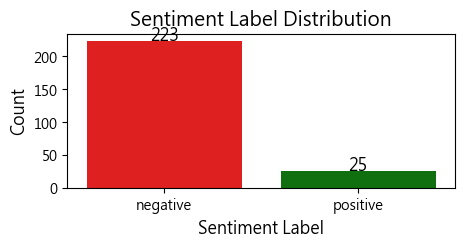

In [10]:
# 計算每種情緒的數量
sentiment_counts = dfJ["sentimentLabel"].value_counts()

# 設定繪圖風格
plt.figure(figsize=(5, 2))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette={"positive": "green", "neutral": "gray", "negative": "red"})
plt.xlabel("Sentiment Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Label Distribution", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 顯示數值
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=12)

# 顯示圖表
plt.show()

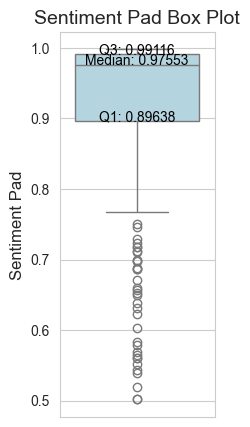

In [11]:
# 確認sentimentPad的分布

# 計算四分位數
Q1 = dfJ["sentimentPad"].quantile(0.25)
Q2 = dfJ["sentimentPad"].median()
Q3 = dfJ["sentimentPad"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(2, 5))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=dfJ["sentimentPad"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Pad Box Plot", fontsize=14)
plt.ylabel("Sentiment Pad", fontsize=12)

# 顯示圖形
plt.show()

## 斷句

In [12]:
df_J = pd.read_csv("./raw_data/zh/Jianing.csv")
df_J["artDate"] = pd.to_datetime(df_J["artDate"]).dt.date 
df_J.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,KeepHard,Gossiping,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""OPPAISuki"", ...",111.252.71.69,2025-03-06 01:25:45,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,signm,Gossiping,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",42.77.145.251,2025-03-12 01:19:13,ptt
2,6,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,THEHELY,Gossiping,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""whitenoise"",...",220.134.27.119,2025-03-12 01:19:38,ptt
3,7,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,fickleness,Gossiping,剛剛看完那個Andy老師的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬Yo...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shine32025"",...",114.136.174.1,2025-03-12 01:19:57,ptt
4,8,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,shokotan,Gossiping,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿\n\n他開的頻道，他找女朋友來一起拍影片，\n\n女...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""jeangodard"",...",111.250.157.109,2025-03-12 01:20:04,ptt


In [13]:
#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
df_J.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
df_J.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
df_J['sentence'] = df_J['artContent'].str.replace(r'\n\n','。', regex=True)
df_J['sentence'] = df_J['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
df_J['sentence'] = df_J['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

df_J.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬Yo...,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿\n\n他開的頻道，他找女朋友來一起拍影片，\n\n女...,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...


In [14]:
# 斷句
df_J['sentence'] = df_J['sentence'].str.split("[,，。！!？?]{1,}")
sent_df_J = df_J.explode('sentence').reset_index(drop=True)
sent_df_J.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉裡的東西被老鼠吃光了
3,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,老鼠都比百姓肥了
4,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,結果百姓在外面餓死 誰的問題


只保留包含 家寧|張家寧|張母|張媽媽

In [15]:
keywords = ["家寧", "張家寧", "張母", "張媽媽"]
filtered_data = [(row["artUrl"], row["artDate"], row["sentence"]) for _, row in sent_df_J.iterrows() if any(kw in row["sentence"] for kw in keywords)]
df_J_only = pd.DataFrame(filtered_data, columns=["artUrl", "artDate", "sentence"])

df_J_only.head()

,artUrl,artDate,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,2025-03-06,大家寧願起義也不願在外面餓死
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,這家人貪婪成這樣還有人會想跟家寧交往嗎
2,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,這個張媽媽是不是已經達到是職業等級的不簡單了


### Sentiment

#### SnowNLP

In [16]:
# 幫每句話加上情緒分數
df_J_only['sentimentValue'] = df_J_only.apply(lambda row : get_sentiment(row['sentence'],), axis = 1).round(5)
df_J_only.head()

,artUrl,artDate,sentence,sentimentValue
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,2025-03-06,大家寧願起義也不願在外面餓死,0.0650
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,這家人貪婪成這樣還有人會想跟家寧交往嗎,0.0032
2,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.1041
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.0000
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,這個張媽媽是不是已經達到是職業等級的不簡單了,0.7503


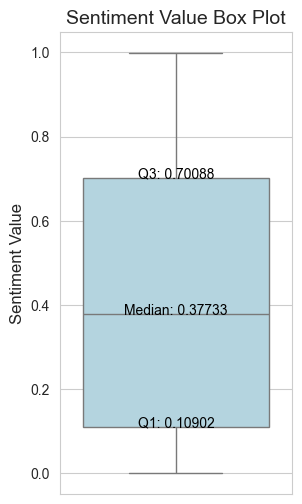

In [17]:
# 確認sentimentValue的分布

# 計算四分位數
Q1 = df_J_only["sentimentValue"].quantile(0.25)
Q2 = df_J_only["sentimentValue"].median()
Q3 = df_J_only["sentimentValue"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(3, 6))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=df_J_only["sentimentValue"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Value Box Plot", fontsize=14)
plt.ylabel("Sentiment Value", fontsize=12)

# 顯示圖形
plt.show()

#### Lexicon-based

In [18]:
for category in emotion_categories:
    df_J_only[category] = 0

# 計算每個句子的情緒詞數，存入 DataFrame
df_J_only[emotion_categories] = df_J_only["sentence"].apply(count_emotion_words)
df_J_only.head()

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,2025-03-06,大家寧願起義也不願在外面餓死,0.0650,0,0,0,0,0,0
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,這家人貪婪成這樣還有人會想跟家寧交往嗎,0.0032,3,1,0,0,0,0
2,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.1041,1,0,0,0,0,0
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.0000,2,0,2,0,0,0
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,這個張媽媽是不是已經達到是職業等級的不簡單了,0.7503,2,1,1,0,0,0


#### Sentiment Score （自定義）

In [19]:
# 用positive和negative的數量評估情緒傾向（設定為0.477，因為資料的Q2為0.377）
df_J_only["sentimentScore"] = df_J_only.apply(lambda row: 
    row["sentimentValue"] + 0.477 if row["positive"] > row["negative"] else 
    row["sentimentValue"] - 0.477 if row["positive"] < row["negative"] else 
    row["sentimentValue"], axis=1)
# df_J_only.drop(columns=["positive", "negative"], inplace=True)

df_J_only.head()

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad,sentimentScore
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,2025-03-06,大家寧願起義也不願在外面餓死,0.0650,0,0,0,0,0,0,0.0650
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,這家人貪婪成這樣還有人會想跟家寧交往嗎,0.0032,3,1,0,0,0,0,-0.4738
2,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.1041,1,0,0,0,0,0,0.1041
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.0000,2,0,2,0,0,0,0.4770
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,這個張媽媽是不是已經達到是職業等級的不簡單了,0.7503,2,1,1,0,0,0,0.7503


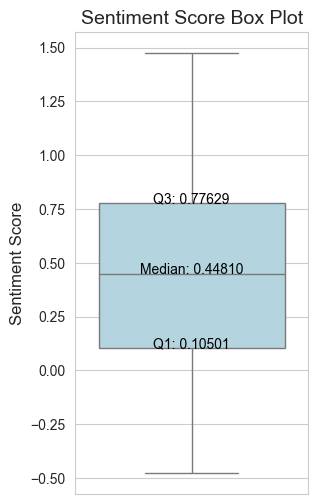

In [20]:
# 確認sentimentScore的分布

# 計算四分位數
Q1 = df_J_only["sentimentScore"].quantile(0.25)
Q2 = df_J_only["sentimentScore"].median()
Q3 = df_J_only["sentimentScore"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(3, 6))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=df_J_only["sentimentScore"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Score Box Plot", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=12)

# 顯示圖形
plt.show()

#### Paddle Label

In [21]:
df_J_only["sentimentLabel"] = df_J_only["sentence"].apply(lambda x: sentiment(x)[0]["label"])
df_J_only["sentimentPad"] = df_J_only["sentence"].apply(lambda x: sentiment(x)[0]["score"])
df_J_only.head(3)

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad,sentimentScore,sentimentLabel,sentimentPad
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,2025-03-06,大家寧願起義也不願在外面餓死,0.0650,0,0,0,0,0,0,0.0650,negative,0.963357
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,這家人貪婪成這樣還有人會想跟家寧交往嗎,0.0032,3,1,0,0,0,0,-0.4738,negative,0.575362
2,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.1041,1,0,0,0,0,0,0.1041,negative,0.647946


In [22]:
# 定義計算 PadScore 的函數
def calculate_padscore(group):
    """ 計算每篇文章的平均 sentimentPad 分數 """
    scores = group.apply(lambda row: -row['sentimentPad'] if row['sentimentLabel'] == 'negative' else row['sentimentPad'], axis=1)
    return scores.mean()  # 計算平均值

# 計算每篇文章的 PadScore（按 artUrl 分組）
pad_scores = df_J_only.groupby("artUrl").apply(calculate_padscore).reset_index()
pad_scores.columns = ["artUrl", "PadScore"]

# 合併回 dfJ
dfJ = dfJ.merge(pad_scores, on="artUrl", how="left").fillna({"PadScore": 0})

dfJ.head()

C:\Users\user\AppData\Local\Temp\ipykernel_12232\304569045.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pad_scores = df_J_only.groupby("artUrl").apply(calculate_padscore).reset_index()


,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad,PadScore
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...,negative,0.994811,-0.963357
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887,0.000000
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643,-0.575362
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244,-0.225026
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...,negative,0.987625,-0.887872


In [23]:
# 依據 PadScore 設定 sentiment 類別
def categorize_sentiment(score):
    if score > 0.3:
        return "positive"
    elif score < -0.3:
        return "negative"
    else:
        return "neutral"
    
dfJ["PadSentiment"] = dfJ["PadScore"].apply(categorize_sentiment)
dfJ.head()

,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad,PadScore,PadSentiment
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...,negative,0.994811,-0.963357,negative
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887,0.000000,neutral
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643,-0.575362,negative
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244,-0.225026,neutral
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...,negative,0.987625,-0.887872,negative


## 趨勢圖

#### 每日文章討論數

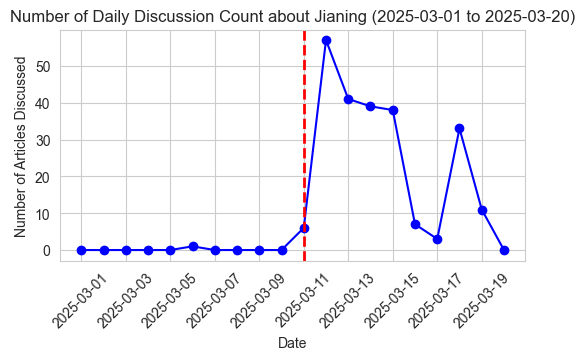

In [31]:
# 計算每日文章討論數（相同 artUrl 代表同一篇文章，只計數一次）
daily_counts = df_J_only.drop_duplicates(subset=["artUrl"]).groupby("artDate").size()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_counts = daily_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles Discussed")
plt.title("Number of Daily Discussion Count about Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### 每日平均情緒分數（自定義）

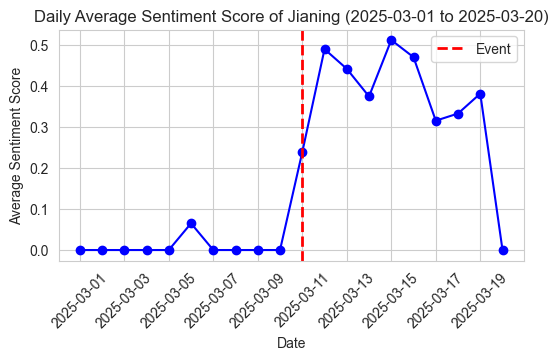

In [30]:
# 計算每日平均情緒分數
avg_sentiment_J = df_J_only.groupby("artDate")["sentimentScore"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentiment_J = avg_sentiment_J.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(avg_sentiment_J.index, avg_sentiment_J.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Daily Average Sentiment Score of Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

#### 每日平均 SnowNLP score

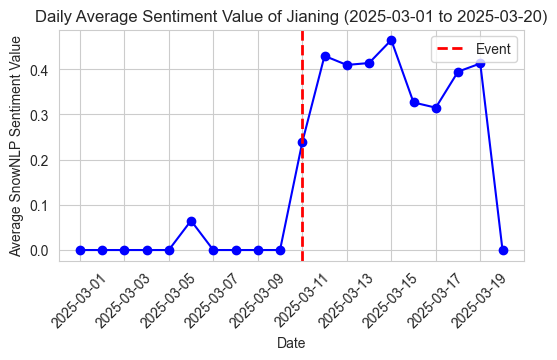

In [29]:
# 計算每日平均情緒分數
avg_sentValue_J = df_J_only.groupby("artDate")["sentimentValue"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentValue_J = avg_sentValue_J.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(avg_sentValue_J.index, avg_sentValue_J.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average SnowNLP Sentiment Value")
plt.title("Daily Average Sentiment Value of Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

### 每日平均 PaddleNLP 分數

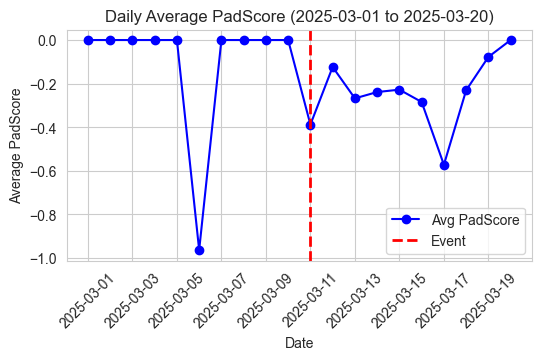

In [28]:
# 計算每日平均 PadScore
daily_padscore = dfJ.groupby("artDate")["PadScore"].mean()

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_padscore = daily_padscore.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(daily_padscore.index, daily_padscore.values, marker='o', linestyle='-', color='b', label="Avg PadScore")
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average PadScore")
plt.title("Daily Average PadScore (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

### 每日正負面文章數（PaddleNLP）

In [32]:
dfJ['PadScore'].min(), dfJ['PadScore'].max()

(-0.9948701858520508, 0.9667232036590576)

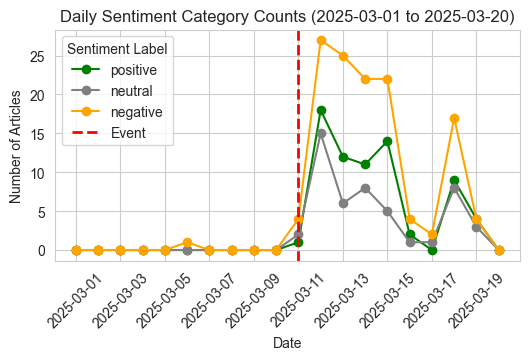

In [34]:
# 計算每日 sentiment 類別數量
daily_sentiment_counts = dfJ.groupby(["artDate", "PadSentiment"]).size().unstack(fill_value=0)

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_sentiment_counts = daily_sentiment_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
for label, color in zip(["positive", "neutral", "negative"], ["green", "gray", "orange"]):
    if label in daily_sentiment_counts.columns:  # 確保該類別存在
        plt.plot(daily_sentiment_counts.index, daily_sentiment_counts[label], marker='o', linestyle='-', color=color, label=label)
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Sentiment Category Counts (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Label")
plt.grid(True)
plt.show()

### 每日正負面文章數（文章層級計算）

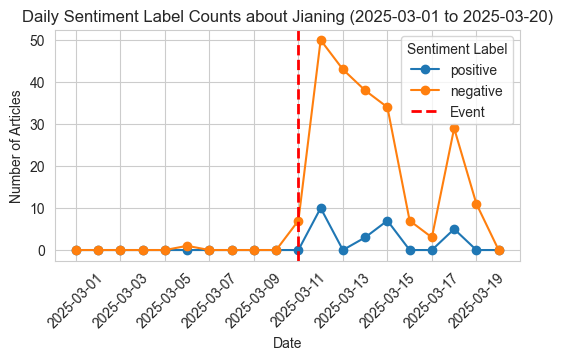

In [35]:
# 計算每日 sentimentLabel 類別數量
daily_sentiment_counts = dfJ.groupby(["artDate", "sentimentLabel"]).size().unstack(fill_value=0)

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_sentiment_counts = daily_sentiment_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
for label in ["positive", "neutral", "negative"]:
    if label in daily_sentiment_counts.columns:  # 避免某天沒有該類別導致 KeyError
        plt.plot(daily_sentiment_counts.index, daily_sentiment_counts[label], marker='o', linestyle='-', label=label)
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Sentiment Label Counts about Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Label")
plt.grid(True)
plt.show()

# ANDY

## 文章 - PaddleNLP Score

In [36]:
dfA = pd.read_csv("./raw_data/zh/AndyTC.csv")
dfA["artDate"] = pd.to_datetime(dfA["artDate"]).dt.date 

# 去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
dfA.drop(drop_cols, axis = 1, inplace = True)

# 去除文章內容為空值的筆數
dfA.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
dfA['artContent'] = dfA['artContent'].str.replace(r'\n\n','。', regex=True)
dfA['artContent'] = dfA['artContent'].str.replace(r'\n','', regex=True)

# # 移除內文中的網址
# dfA['artContent'] = dfA['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
# dfA.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

dfA.head(3)

,artUrl,artTitle,artDate,artContent
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...


In [37]:
def convert_sentiment(row):
    if row["sentimentLabel"] == "positive":
        return row["sentimentPad"]  # 直接使用 score，範圍 0 ~ 1
    elif row["sentimentLabel"] == "negative":
        return -row["sentimentPad"]  # 轉成負數，範圍 -1 ~ 0
    else:
        return 0  # 中性

dfA["sentimentLabel"] = dfA["artContent"].apply(lambda x: sentiment(x)[0]["label"])
dfA["sentimentPad"] = dfA["artContent"].apply(lambda x: sentiment(x)[0]["score"])
# dfJ["sentimentPad"]= dfJ.apply(convert_sentiment, axis=1)

dfA.head()

,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,negative,0.970684
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244
4,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,Andy老師拍片爆料家寧一家的黑幕但是當初股份什麼的都是白紙黑字簽好的而且家寧媽媽看起來也是...,negative,0.896491


C:\Users\user\AppData\Local\Temp\ipykernel_12232\3843456844.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette={"positive": "green", "neutral": "gray", "negative": "red"})


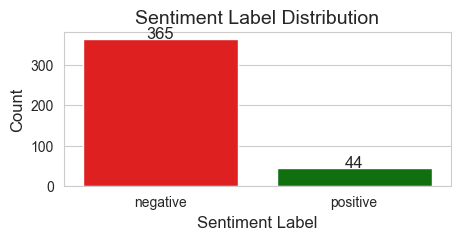

In [38]:
# 計算每種情緒的數量
sentiment_counts = dfA["sentimentLabel"].value_counts()

# 設定繪圖風格
plt.figure(figsize=(5, 2))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette={"positive": "green", "neutral": "gray", "negative": "red"})
plt.xlabel("Sentiment Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Label Distribution", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 顯示數值
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=12)

# 顯示圖表
plt.show()

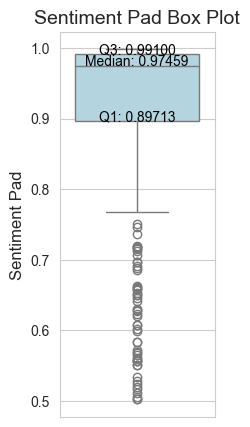

In [39]:
# 確認sentimentPad的分布

# 計算四分位數
Q1 = dfA["sentimentPad"].quantile(0.25)
Q2 = dfA["sentimentPad"].median()
Q3 = dfA["sentimentPad"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(2, 5))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=dfA["sentimentPad"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Pad Box Plot", fontsize=14)
plt.ylabel("Sentiment Pad", fontsize=12)

# 顯示圖形
plt.show()

## 斷句

In [40]:
df_A = pd.read_csv("./raw_data/zh/AndyTC.csv")
df_A["artDate"] = pd.to_datetime(df_A["artDate"]).dt.date 
df_A.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,2,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,signm,Gossiping,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",42.77.145.251,2025-03-12 01:19:13,ptt
1,3,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,renna038766,Gossiping,剛看完 Andy老師太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Tris101"", ""c...",118.166.74.82,2025-03-12 01:19:26,ptt
2,6,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,THEHELY,Gossiping,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""whitenoise"",...",220.134.27.119,2025-03-12 01:19:38,ptt
3,7,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,fickleness,Gossiping,剛剛看完那個Andy老師的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬Yo...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shine32025"",...",114.136.174.1,2025-03-12 01:19:57,ptt
4,9,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,chocobo4235,Gossiping,Andy老師拍片爆料家寧一家的黑幕\n但是當初股份什麼的都是白紙黑字簽好的\n而且家寧媽媽看...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cs09312"", ""c...",42.74.151.49,2025-03-12 01:20:11,ptt


In [41]:
#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
df_A.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
df_A.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
df_A['sentence'] = df_A['artContent'].str.replace(r'\n\n','。', regex=True)
df_A['sentence'] = df_A['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
df_A['sentence'] = df_A['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

df_A.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳...,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬Yo...,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...
4,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,Andy老師拍片爆料家寧一家的黑幕\n但是當初股份什麼的都是白紙黑字簽好的\n而且家寧媽媽看...,Andy老師拍片爆料家寧一家的黑幕但是當初股份什麼的都是白紙黑字簽好的而且家寧媽媽看起來也是...


In [42]:
# 斷句
df_A['sentence'] = df_A['sentence'].str.split("[,，。！!？?]{1,}")
sent_df_A = df_A.explode('sentence').reset_index(drop=True)
sent_df_A.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳...,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題
3,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,看完Andy才知道這家人吃相超難看
4,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工


只保留包含 ANDY|Andy|andy

In [43]:
keywords = ["ANDY", "Andy", "andy"]
filtered_data = [(row["artUrl"], row["artDate"], row["sentence"]) for _, row in sent_df_A.iterrows() if any(kw in row["sentence"] for kw in keywords)]
df_A_only = pd.DataFrame(filtered_data, columns=["artUrl", "artDate", "sentence"])

df_A_only.head()

,artUrl,artDate,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,看完Andy才知道這家人吃相超難看
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...


### Sentiment

#### SnowNLP

In [44]:
# 幫每句話加上情緒分數
df_A_only['sentimentValue'] = df_A_only.apply(lambda row : get_sentiment(row['sentence'],), axis = 1).round(5)
df_A_only.head()

,artUrl,artDate,sentence,sentimentValue
0,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,0.00007
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,看完Andy才知道這家人吃相超難看,0.86839
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工,0.00006
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.10410
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.00000


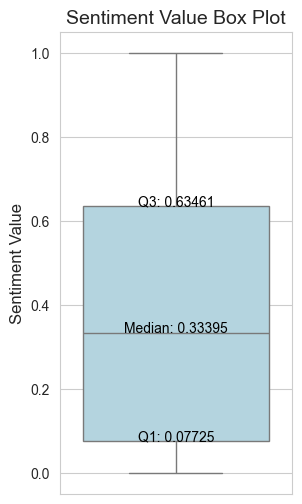

In [45]:
# 確認sentimentValue的分布

# 計算四分位數
Q1 = df_A_only["sentimentValue"].quantile(0.25)
Q2 = df_A_only["sentimentValue"].median()
Q3 = df_A_only["sentimentValue"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(3, 6))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=df_A_only["sentimentValue"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Value Box Plot", fontsize=14)
plt.ylabel("Sentiment Value", fontsize=12)

# 顯示圖形
plt.show()

#### Lexicon-based

In [46]:
for category in emotion_categories:
    df_A_only[category] = 0
    
# 計算每個句子的情緒詞數，存入 DataFrame
df_A_only[emotion_categories] = df_A_only["sentence"].apply(count_emotion_words)
df_A_only.head()

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad
0,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,0.00007,3,1,1,0,0,0
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,看完Andy才知道這家人吃相超難看,0.86839,1,1,0,0,1,0
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工,0.00006,1,1,0,0,0,0
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.10410,1,0,0,0,0,0
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.00000,2,0,2,0,0,0


#### Sentiment Score （自定義）

In [47]:
# 用positive和negative的數量評估情緒傾向（設定為0.433，因為資料的Q2為0.333）
df_A_only["sentimentEdit"] = df_A_only.apply(lambda row: 
    0.433 if row["positive"] > row["negative"] else 
    -0.433 if row["positive"] < row["negative"] else 
    0, axis=1)
# df_A_only.drop(columns=["positive", "negative"], inplace=True)

# 用加減分的方式進行影響
df_A_only["sentimentScore"] = df_A_only["sentimentValue"] + df_A_only["sentimentEdit"]

df_A_only.head()

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad,sentimentEdit,sentimentScore
0,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,0.00007,3,1,1,0,0,0,0.000,0.00007
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,看完Andy才知道這家人吃相超難看,0.86839,1,1,0,0,1,0,-0.433,0.43539
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工,0.00006,1,1,0,0,0,0,-0.433,-0.43294
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊,0.10410,1,0,0,0,0,0,0.000,0.10410
4,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,2025-03-11,百萬YouTube10年來有接業配應該已經賺到財富自由了張媽媽居然可以做到一手遮天搞帳目搞經...,0.00000,2,0,2,0,0,0,0.433,0.43300


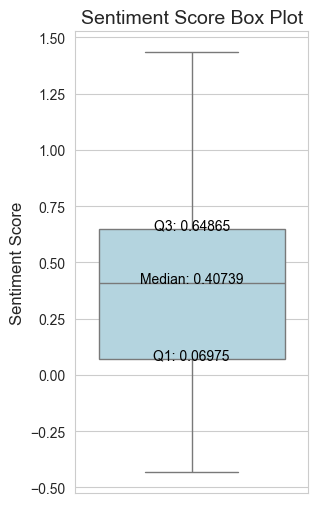

In [48]:
# 確認sentimentScore的分布

# 計算四分位數
Q1 = df_A_only["sentimentScore"].quantile(0.25)
Q2 = df_A_only["sentimentScore"].median()
Q3 = df_A_only["sentimentScore"].quantile(0.75)

# 設定圖形大小與風格
plt.figure(figsize=(3, 6))
sns.set_style("whitegrid")

# 繪製箱形圖
sns.boxplot(y=df_A_only["sentimentScore"], color="lightblue")

# 在圖上標記四分位數
plt.text(0, Q1, f"Q1: {Q1:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q2, f"Median: {Q2:.5f}", ha='center', fontsize=10, color='black')
plt.text(0, Q3, f"Q3: {Q3:.5f}", ha='center', fontsize=10, color='black')

# 設定標題與標籤
plt.title("Sentiment Score Box Plot", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=12)

# 顯示圖形
plt.show()

#### Paddle Label

In [49]:
df_A_only["sentimentLabel"] = df_A_only["sentence"].apply(lambda x: sentiment(x)[0]["label"])
df_A_only["sentimentPad"] = df_A_only["sentence"].apply(lambda x: sentiment(x)[0]["score"])
df_A_only.head(3)

,artUrl,artDate,sentence,sentimentValue,affect,negative,positive,anx,anger,sad,sentimentEdit,sentimentScore,sentimentLabel,sentimentPad
0,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,0.00007,3,1,1,0,0,0,0.000,0.00007,negative,0.970684
1,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,看完Andy才知道這家人吃相超難看,0.86839,1,1,0,0,1,0,-0.433,0.43539,negative,0.784759
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,2025-03-11,一個200萬訂閱 每個月才給5.5萬薪水不給查帳 還把Andy當員工,0.00006,1,1,0,0,0,0,-0.433,-0.43294,negative,0.563324


In [50]:
# 定義計算 PadScore 的函數
def calculate_padscore(group):
    """ 計算每篇文章的平均 sentimentPad 分數 """
    scores = group.apply(lambda row: -row['sentimentPad'] if row['sentimentLabel'] == 'negative' else row['sentimentPad'], axis=1)
    return scores.mean()  # 計算平均值

# 計算每篇文章的 PadScore（按 artUrl 分組）
pad_scores = df_A_only.groupby("artUrl").apply(calculate_padscore).reset_index()
pad_scores.columns = ["artUrl", "PadScore"]

# 合併回 dfA
dfA = dfA.merge(pad_scores, on="artUrl", how="left").fillna({"PadScore": 0})

dfA.head()

C:\Users\user\AppData\Local\Temp\ipykernel_12232\4256551355.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pad_scores = df_A_only.groupby("artUrl").apply(calculate_padscore).reset_index()


,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad,PadScore
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887,0.000000
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,negative,0.970684,-0.970684
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643,-0.674042
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244,0.064995
4,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,Andy老師拍片爆料家寧一家的黑幕但是當初股份什麼的都是白紙黑字簽好的而且家寧媽媽看起來也是...,negative,0.896491,-0.013664


In [51]:
# 依據 PadScore 設定 sentiment 類別
def categorize_sentiment(score):
    if score > 0.3:
        return "positive"
    elif score < -0.3:
        return "negative"
    else:
        return "neutral"
    
dfA["PadSentiment"] = dfA["PadScore"].apply(categorize_sentiment)
dfA.head()

,artUrl,artTitle,artDate,artContent,sentimentLabel,sentimentPad,PadScore,PadSentiment
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,negative,0.927887,0.000000,neutral
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy老師太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 ...,negative,0.970684,-0.970684,negative
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...,negative,0.899643,-0.674042,negative
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube1...,negative,0.937244,0.064995,neutral
4,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,Andy老師拍片爆料家寧一家的黑幕但是當初股份什麼的都是白紙黑字簽好的而且家寧媽媽看起來也是...,negative,0.896491,-0.013664,neutral


## 趨勢圖

#### 每日文章討論數

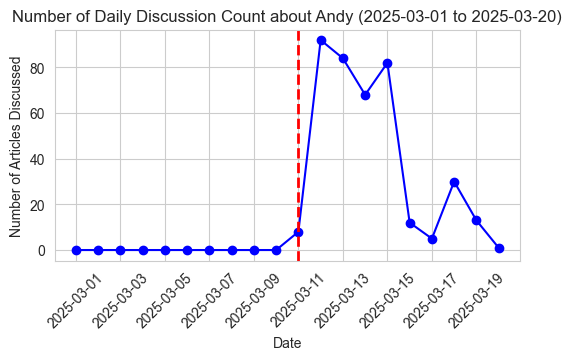

In [52]:
# 計算每日文章討論數（相同 artUrl 代表同一篇文章，只計數一次）
daily_counts = df_A_only.drop_duplicates(subset=["artUrl"]).groupby("artDate").size()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_counts = daily_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles Discussed")
plt.title("Number of Daily Discussion Count about Andy (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

#### 每日平均情緒分數

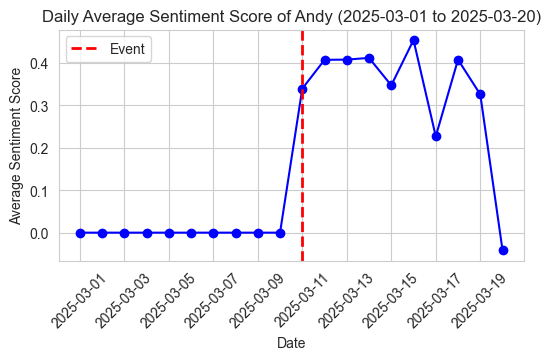

In [53]:
# 計算每日平均情緒分數
avg_sentiment_A = df_A_only.groupby("artDate")["sentimentScore"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentiment_A = avg_sentiment_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(avg_sentiment_A.index, avg_sentiment_A.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Daily Average Sentiment Score of Andy (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

#### 每日平均 SnowNLP score

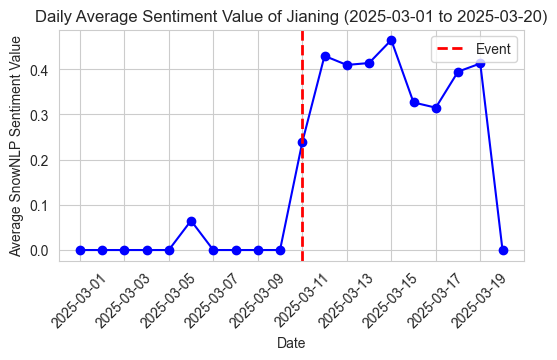

In [54]:
# 計算每日平均情緒分數
avg_sentValue_A = df_J_only.groupby("artDate")["sentimentValue"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentValue_A = avg_sentValue_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(avg_sentValue_A.index, avg_sentValue_A.values, marker='o', linestyle='-', color='b')
# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average SnowNLP Sentiment Value")
plt.title("Daily Average Sentiment Value of Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

### 每日平均 PaddleNLP score

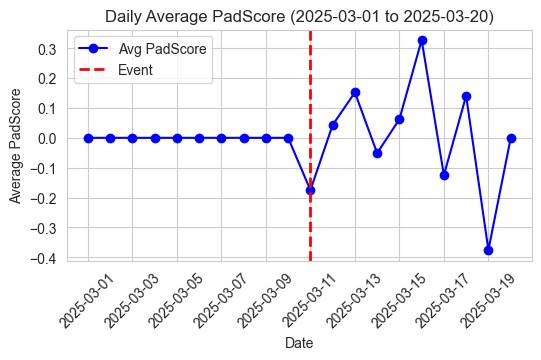

In [55]:
# 計算每日平均 PadScore
daily_padscore = dfA.groupby("artDate")["PadScore"].mean()

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_padscore = daily_padscore.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
plt.plot(daily_padscore.index, daily_padscore.values, marker='o', linestyle='-', color='b', label="Avg PadScore")
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Average PadScore")
plt.title("Daily Average PadScore (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

### 每日正負面文章數（PaddleNLP）

In [56]:
dfA['PadScore'].min(), dfA['PadScore'].max()

(-0.9948701858520508, 0.9859519898891449)

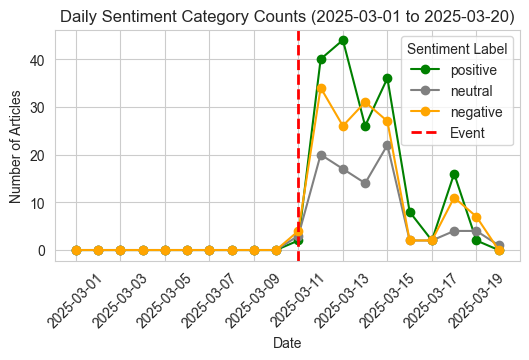

In [57]:
# 計算每日 sentiment 類別數量
daily_sentiment_counts = dfA.groupby(["artDate", "PadSentiment"]).size().unstack(fill_value=0)

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_sentiment_counts = daily_sentiment_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
for label, color in zip(["positive", "neutral", "negative"], ["green", "gray", "orange"]):
    if label in daily_sentiment_counts.columns:  # 確保該類別存在
        plt.plot(daily_sentiment_counts.index, daily_sentiment_counts[label], marker='o', linestyle='-', color=color, label=label)
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Sentiment Category Counts (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Label")
plt.grid(True)
plt.show()

### 每日正負面文章數（文章層級計算）

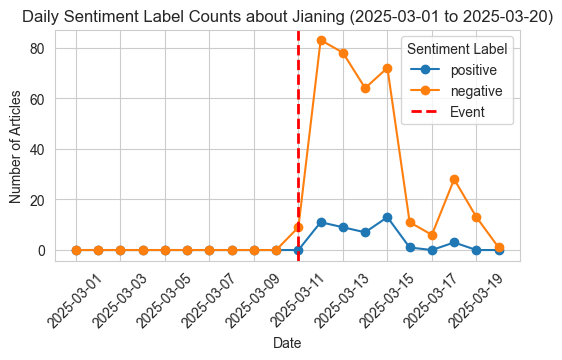

In [59]:
# 計算每日 sentimentLabel 類別數量
daily_sentiment_counts = dfA.groupby(["artDate", "sentimentLabel"]).size().unstack(fill_value=0)

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_sentiment_counts = daily_sentiment_counts.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))
for label in ["positive", "neutral", "negative"]:
    if label in daily_sentiment_counts.columns:  # 避免某天沒有該類別導致 KeyError
        plt.plot(daily_sentiment_counts.index, daily_sentiment_counts[label], marker='o', linestyle='-', label=label)
# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='r', linestyle='--', linewidth=2, label="Event")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Sentiment Label Counts about Jianing (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Label")
plt.grid(True)
plt.show()

# 比較

#### 每日文章討論數

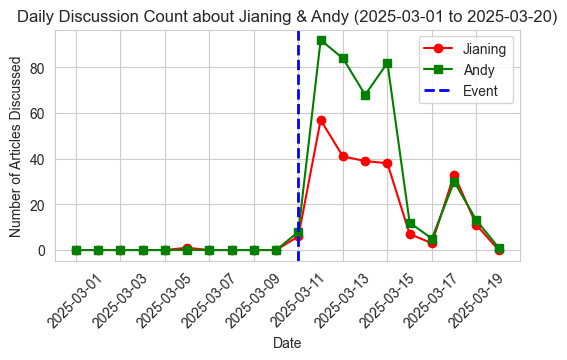

In [61]:
# 計算每日文章討論數（相同 artUrl 代表同一篇文章，只計數一次）
daily_counts_J = df_J_only.drop_duplicates(subset=["artUrl"]).groupby("artDate").size()
daily_counts_A = df_A_only.drop_duplicates(subset=["artUrl"]).groupby("artDate").size()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_counts_J = daily_counts_J.reindex(date_range, fill_value=0)
daily_counts_A = daily_counts_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))

# 繪製兩條線
plt.plot(daily_counts_J.index, daily_counts_J.values, marker='o', linestyle='-', color='r', label="Jianing")
plt.plot(daily_counts_A.index, daily_counts_A.values, marker='s', linestyle='-', color='g', label="Andy")

# 添加 3/11 的虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='b', linestyle='--', linewidth=2, label="Event")

# 圖表標籤
plt.xlabel("Date")
plt.ylabel("Number of Articles Discussed")
plt.title("Daily Discussion Count about Jianing & Andy (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # 顯示圖例

# 顯示圖表
plt.show()

#### 每日平均情緒分數（自定義）

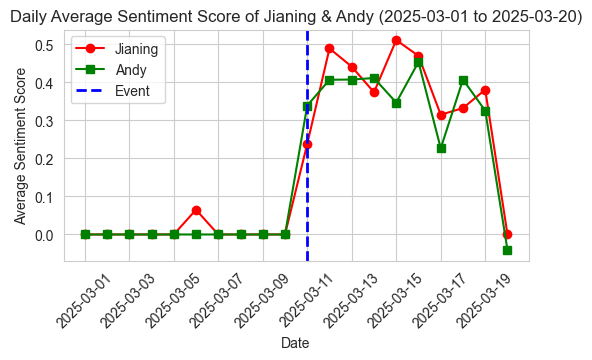

In [62]:
# 計算每日平均情緒分數
avg_sentiment_J = df_J_only.groupby("artDate")["sentimentScore"].mean()
avg_sentiment_A = df_A_only.groupby("artDate")["sentimentScore"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentiment_J = avg_sentiment_J.reindex(date_range, fill_value=0)
avg_sentiment_A = avg_sentiment_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))

# 繪製兩條線
plt.plot(avg_sentiment_J.index, avg_sentiment_J.values, marker='o', linestyle='-', color='r', label="Jianing")
plt.plot(avg_sentiment_A.index, avg_sentiment_A.values, marker='s', linestyle='-', color='g', label="Andy")

# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='b', linestyle='--', linewidth=2, label="Event")

# 圖表標籤
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Daily Average Sentiment Score of Jianing & Andy (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # 顯示圖例

# 顯示圖表
plt.show()

#### 每日平均 SnowNLP score

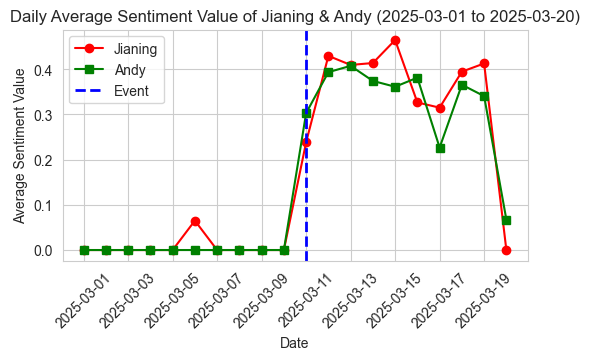

In [64]:
# 計算每日平均情緒分數
avg_sentValue_J = df_J_only.groupby("artDate")["sentimentValue"].mean()
avg_sentValue_A = df_A_only.groupby("artDate")["sentimentValue"].mean()

# 生成 3/1 到 3/20 的完整日期範圍
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
avg_sentValue_J = avg_sentValue_J.reindex(date_range, fill_value=0)
avg_sentValue_A = avg_sentValue_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))

# 繪製兩條線
plt.plot(avg_sentValue_J.index, avg_sentValue_J.values, marker='o', linestyle='-', color='r', label="Jianing")
plt.plot(avg_sentValue_A.index, avg_sentValue_A.values, marker='s', linestyle='-', color='g', label="Andy")

# 添加 3/11 的紅色虛線
plt.axvline(pd.to_datetime("2025-03-11"), color='b', linestyle='--', linewidth=2, label="Event")

# 圖表標籤
plt.xlabel("Date")
plt.ylabel("Average Sentiment Value")
plt.title("Daily Average Sentiment Value of Jianing & Andy (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # 顯示圖例

# 顯示圖表
plt.show()

### 每日平均 PaddleNLP Score

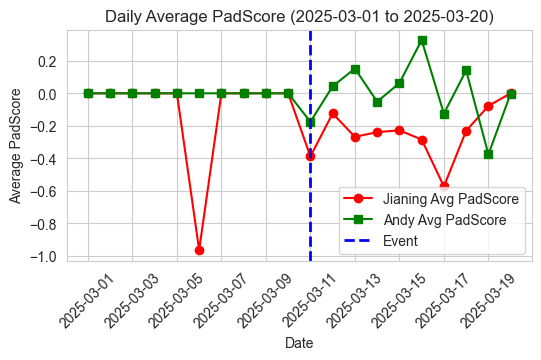

In [65]:
# 計算每日平均 PadScore
daily_padscore_J = dfJ.groupby("artDate")["PadScore"].mean()
daily_padscore_A = dfA.groupby("artDate")["PadScore"].mean()

# 確保日期範圍完整，即使某天沒有文章
date_range = pd.date_range(start="2025-03-01", end="2025-03-20")
daily_padscore_J = daily_padscore_J.reindex(date_range, fill_value=0)
daily_padscore_A = daily_padscore_A.reindex(date_range, fill_value=0)

# 繪製折線圖
plt.figure(figsize=(6, 3))

# dfJ 
plt.plot(daily_padscore_J.index, daily_padscore_J.values, marker='o', linestyle='-', color='r', label="Jianing Avg PadScore")

# dfA 
plt.plot(daily_padscore_A.index, daily_padscore_A.values, marker='s', linestyle='-', color='g', label="Andy Avg PadScore")

# 添加 3/11 的紅色虛線
event_date = pd.to_datetime("2025-03-11")
plt.axvline(event_date, color='b', linestyle='--', linewidth=2, label="Event")

# 添加標題 & 標籤
plt.xlabel("Date")
plt.ylabel("Average PadScore")
plt.title("Daily Average PadScore (2025-03-01 to 2025-03-20)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

# WordCloud

In [219]:
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']

df_WC_J = pd.read_csv("./raw_data/zh/Jianing.csv")
df_WC_J["artDate"] = pd.to_datetime(df_WC_J["artDate"]).dt.date
df_WC_J.drop(drop_cols, axis = 1, inplace = True)

df_WC_A = pd.read_csv("./raw_data/zh/AndyTC.csv")
df_WC_A["artDate"] = pd.to_datetime(df_WC_A["artDate"]).dt.date 
df_WC_A.drop(drop_cols, axis = 1, inplace = True)

df_WC = pd.concat([df_WC_J, df_WC_A]).drop_duplicates(subset=["artUrl"]).reset_index(drop=True)

print(df_WC_J.shape, df_WC_A.shape, df_WC.shape)
df_WC.head()

(248, 4) (409, 4) (497, 4)


,artUrl,artTitle,artDate,artContent
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy老師的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬Yo...
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿\n\n他開的頻道，他找女朋友來一起拍影片，\n\n女...


In [220]:
df_WC["artContent"] = df_WC["artContent"].str.replace(r'(?i)andy老師|andy|ANDY', 'Andy', regex=True)
df_WC_J["artContent"] = df_WC_J["artContent"].str.replace(r'(?i)andy老師|andy|ANDY', 'Andy', regex=True)
df_WC_A["artContent"] = df_WC_A["artContent"].str.replace(r'(?i)andy老師|andy|ANDY', 'Andy', regex=True)

df_WC["artContent"] = df_WC["artContent"].str.replace('張家寧', '家寧')
df_WC_J["artContent"] = df_WC_J["artContent"].str.replace('張家寧', '家寧')
df_WC_A["artContent"] = df_WC_A["artContent"].str.replace('張家寧', '家寧')

## 眾量級

#### 資料清理

In [162]:
#去除文章內容為空值的筆數
df_WC.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
df_WC['sentence'] = df_WC['artContent'].str.replace(r'\n\n','。', regex=True)
df_WC['sentence'] = df_WC['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
df_WC['sentence'] = df_WC['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

df_WC.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬YouT...,剛剛看完那個Andy的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube10年...
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿\n\n他開的頻道，他找女朋友來一起拍影片，\n\n女...,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...


#### 斷句

In [163]:
df_WC['sentence'] = df_WC['sentence'].str.split("[,，。！!？?]{1,}")
sent_WC_df = df_WC.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_WC_df['sentence'] = sent_WC_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_WC_df = sent_WC_df[sent_WC_df["sentence"].str.len() > 1]

sent_WC_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉裡的東西被老鼠吃光了
3,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,老鼠都比百姓肥了
4,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,結果百姓在外面餓死 誰的問題


#### 斷詞

In [164]:
word_WC_df = sent_WC_df.assign(word = sent_WC_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
word_WC_df = word_WC_df.loc[word_WC_df['word'].str.len() > 1] #去除少於兩個字的詞語
word_WC_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


#### 移除停用字

In [165]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stop_words.txt', 'r', encoding='utf-8').readlines()] 

noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
noStop_WC_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


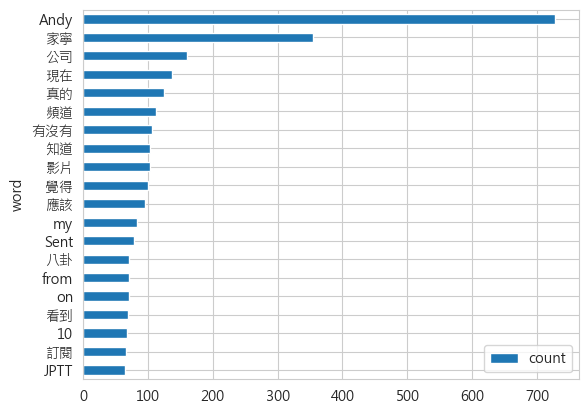

In [166]:
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 1

In [167]:
stopwords_manual = ["真的", "現在", "有沒有", "知道", "覺得", "應該", "my", "Sent", "八卦", "on", "from", "10", "看到", "吃到", "JPTT"]
stopwords.extend(stopwords_manual)

noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
noStop_WC_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


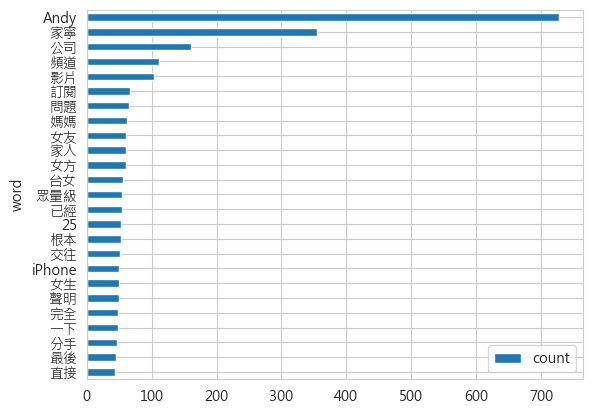

In [168]:
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(25).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 2

In [169]:
stopwords_manual = ["問題", "已經", "25", "根本", "iPhone", "女生", "完全", "一下", "最後", "直接"]
stopwords.extend(stopwords_manual)

noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
noStop_WC_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


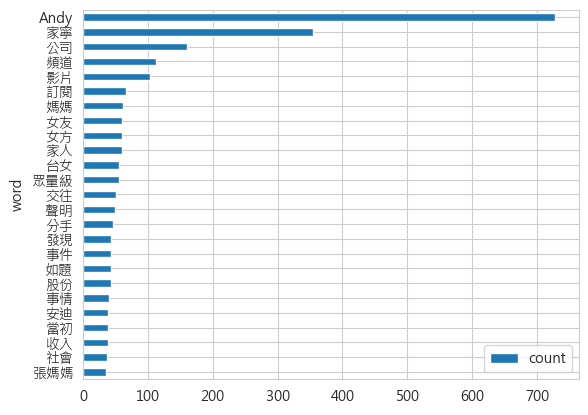

In [170]:
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(25).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 3

In [171]:
stopwords_manual = ["發現", "如題", "當初", "社會"]
stopwords.extend(stopwords_manual)

noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
noStop_WC_df.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,東西


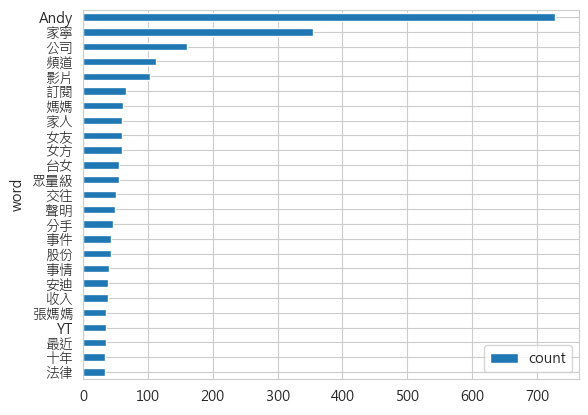

In [172]:
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(25).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 文字雲

In [173]:
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']
print(dict(list(freq_dict.items())[:10]))

{'Andy': 728, '家寧': 355, '公司': 160, '頻道': 112, '影片': 103, '訂閱': 67, '媽媽': 62, '家人': 60, '女友': 60, '女方': 60}


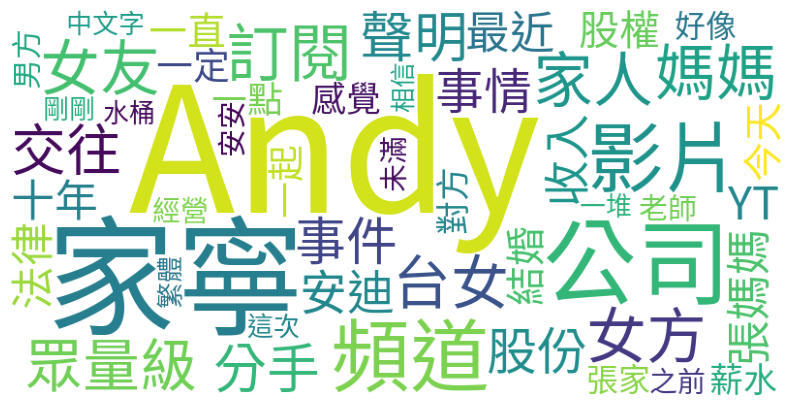

In [176]:
# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

文字雲 - 1

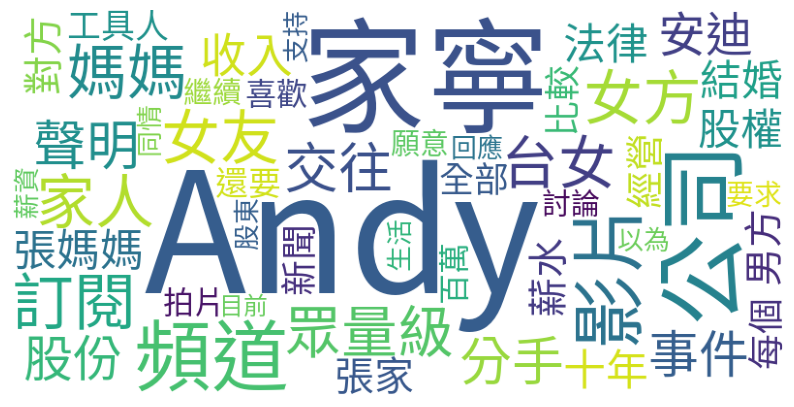

In [178]:
stopwords_manual = ["一直", "一定", "一點", "中文字", "剛剛", "水桶", "安安", "一起", "感覺", "相信", "最近", "好像", "事情", "一堆", "老師", "YT", "今天", "之前", "繁體", "這次", "未滿"]
stopwords.extend(stopwords_manual)
noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

文字雲 - 2

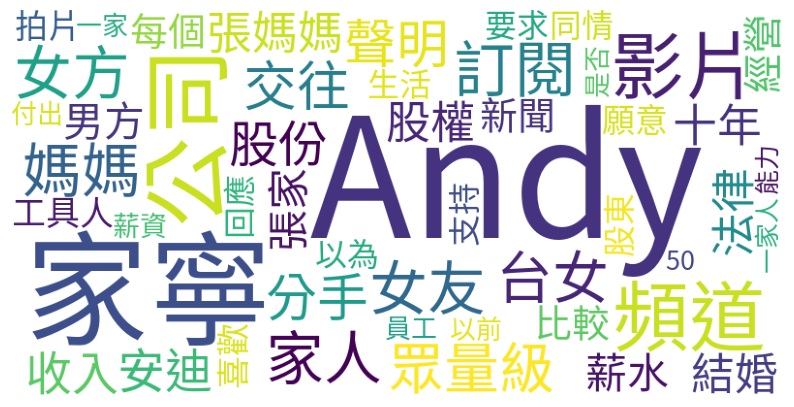

In [ ]:
stopwords_manual = ["對方", "繼續", "還要", "全部", "百萬", "目前", "事件", "討論"]
stopwords.extend(stopwords_manual)
noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

文字雲 - 3

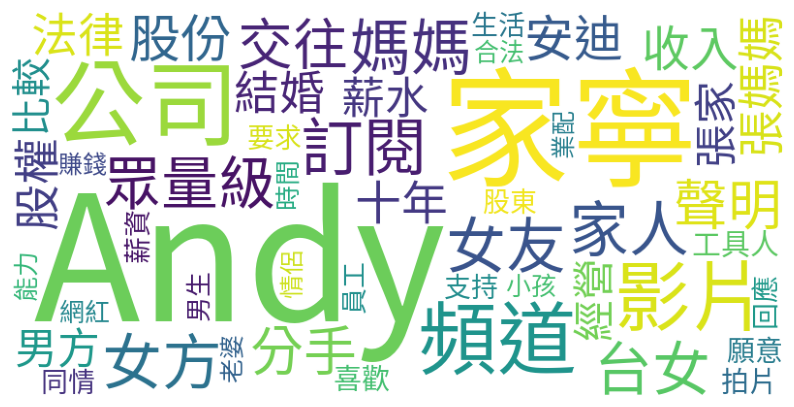

In [185]:
stopwords_manual = ["一家", "一家人", "新聞", "全部", "每個", "以為", "以前", "50", "是否", "之後", "好了", "需要", "至少"]
stopwords.extend(stopwords_manual)
noStop_WC_df = word_WC_df[~word_WC_df['word'].isin(stopwords)]
freq_df = pd.DataFrame(noStop_WC_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

## 家寧

#### 資料清理

In [221]:
#去除文章內容為空值的筆數
df_WC_J.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
df_WC_J['sentence'] = df_WC_J['artContent'].str.replace(r'\n\n','。', regex=True)
df_WC_J['sentence'] = df_WC_J['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
df_WC_J['sentence'] = df_WC_J['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

df_WC_J.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題。百姓名不聊生。糧倉裡的東西被老鼠吃光了。老鼠都比百姓肥了。結果百姓在外面餓死 誰的問題...
1,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬YouT...,剛剛看完那個Andy的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube10年...
4,https://www.ptt.cc/bbs/Gossiping/M.1741698138....,[問卦]眾量級Andy是吃了不懂公司法的虧嗎？,2025-03-11,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿\n\n他開的頻道，他找女朋友來一起拍影片，\n\n女...,ＹｏｕＴｕｂｅｒ眾量級的Ａｎｄｙ王崇睿。他開的頻道，他找女朋友來一起拍影片，。女朋友開了公司...


#### 斷句

In [222]:
df_WC_J['sentence'] = df_WC_J['sentence'].str.split("[,，。！!？?]{1,}")
sent_WC_J_df = df_WC_J.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_WC_J_df['sentence'] = sent_WC_J_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_WC_J_df = sent_WC_J_df[sent_WC_J_df["sentence"].str.len() > 1]

sent_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉裡的東西被老鼠吃光了
3,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,老鼠都比百姓肥了
4,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,結果百姓在外面餓死 誰的問題


### 斷詞

In [223]:
# 初始化斷詞引擎
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/yt_dict.txt')

Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
[2025-03-21 17:17:23,316] [   DEBUG] __init__.py:113 - Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
[2025-03-21 17:17:23,318] [   DEBUG] __init__.py:132 - Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
Loading model cost 0.360 seconds.
[2025-03-21 17:17:23,679] [   DEBUG] __init__.py:164 - Loading model cost 0.360 seconds.
Prefix dict has been built successfully.
[2025-03-21 17:17:23,680] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


In [224]:
word_WC_J_df = sent_WC_J_df.assign(word = sent_WC_J_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
word_WC_J_df = word_WC_J_df.loc[word_WC_J_df['word'].str.len() > 1] #去除少於兩個字的詞語
word_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


### 移除停用字

In [225]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stop_words.txt', 'r', encoding='utf-8').readlines()] 

noStop_WC_J_df = word_WC_J_df[~word_WC_J_df['word'].isin(stopwords)]
noStop_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


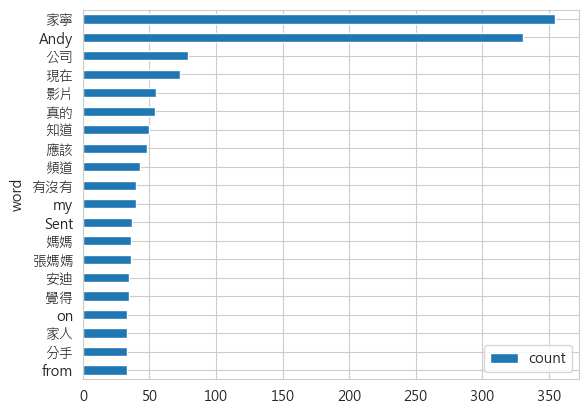

In [226]:
freq_df = pd.DataFrame(noStop_WC_J_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 1

In [227]:
stopwords_manual = ["家寧", "Andy", "公司", "現在", "影片", "真的", "知道", "應該", "有沒有", "my", "Sent", "安迪", "from", "覺得"]
stopwords.extend(stopwords_manual)

noStop_WC_J_df = word_WC_J_df[~word_WC_J_df['word'].isin(stopwords)]
noStop_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,如題
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的


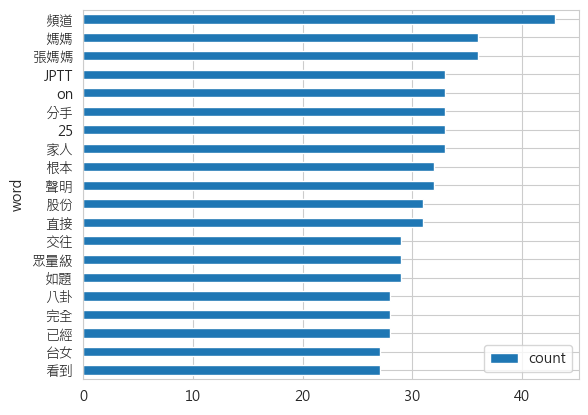

In [228]:
freq_df = pd.DataFrame(noStop_WC_J_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 2

In [229]:
stopwords_manual = ["JPTT", "on", "25", "根本", "直接", "眾量級", "如題", "八卦", "完全", "已經", "看到"]
stopwords.extend(stopwords_manual)

noStop_WC_J_df = word_WC_J_df[~word_WC_J_df['word'].isin(stopwords)]
noStop_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,東西


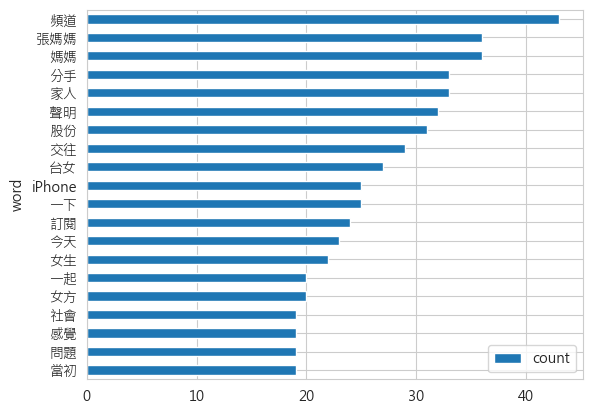

In [230]:
freq_df = pd.DataFrame(noStop_WC_J_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 3

In [231]:
stopwords_manual = ["iPhone", "一下", "今天", "一起", "感覺", "當初", "問題"]
stopwords.extend(stopwords_manual)

noStop_WC_J_df = word_WC_J_df[~word_WC_J_df['word'].isin(stopwords)]
noStop_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,東西


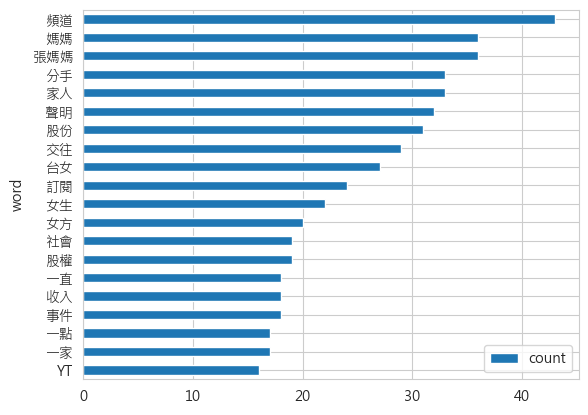

In [232]:
freq_df = pd.DataFrame(noStop_WC_J_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 4

In [233]:
stopwords_manual = ["一直", "事件", "一點", "YT"]
stopwords.extend(stopwords_manual)

noStop_WC_J_df = word_WC_J_df[~word_WC_J_df['word'].isin(stopwords)]
noStop_WC_J_df.head()

,artUrl,artTitle,artDate,artContent,word
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,百姓
1,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,名不聊生
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,糧倉
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,裡的
2,https://www.ptt.cc/bbs/Gossiping/M.1741193790....,[問卦]黃巾起義失敗是什麼問題?,2025-03-06,如題\n\n百姓名不聊生\n\n糧倉裡的東西被老鼠吃光了\n\n老鼠都比百姓肥了\n\n結果...,東西


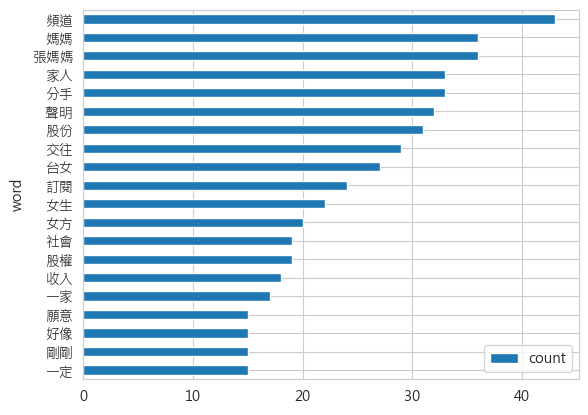

In [234]:
freq_df = pd.DataFrame(noStop_WC_J_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

### 文字雲

In [235]:
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']
print(dict(list(freq_dict.items())[:10]))

{'頻道': 43, '媽媽': 36, '張媽媽': 36, '家人': 33, '分手': 33, '聲明': 32, '股份': 31, '交往': 29, '台女': 27, '訂閱': 24}


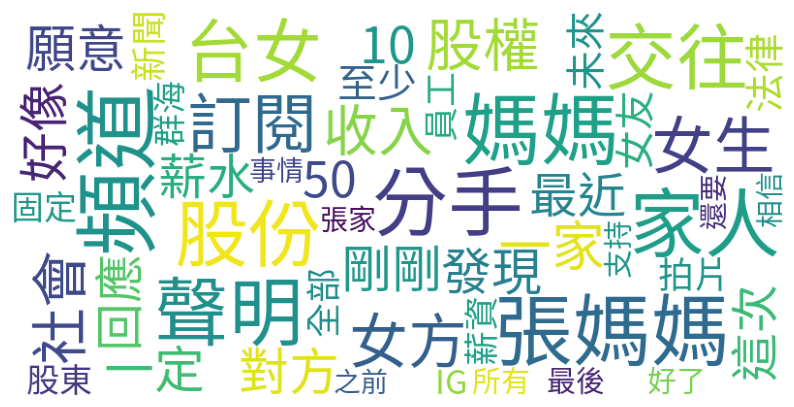

In [236]:
# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

查看提到IG的文章

In [239]:
df_WC_J[df_WC_J["artContent"].str.contains("IG", na=False, case=False)][["artTitle", "artDate", "artContent"]]

,artTitle,artDate,artContent
10,[爆卦]重量級ansy新片破100萬了,2025-03-12,https://i.imgur.com/XBPapYk.png\n看家寧ig真的好多名牌\n...
17,[問卦]張家寧今天會出來蜜月期popo嗎？,2025-03-12,相比Andy變得如此落魄\n從IG可以看得出來家寧過得好滋潤\n家寧今天應該要出來po個什麼...
24,[問卦]家寧算是超正妹吧？,2025-03-12,今天看到板上在吵家寧跟Andy事情\n\n原本不太認識他們\n\n跑去看了一下IG\n\n覺...
35,[問卦]家寧跳的舞是跟莊圓大師學的嗎？,2025-03-12,剛剛跑去看家寧的IG\n\n發現一大堆人在她最新的貼文底下留言罵她\n\n然後那篇貼文是她在...
63,[問卦]家寧她媽MVP她妹躺贏夠能這樣說嗎？,2025-03-12,幹家寧他媽真的很有腦欸\n\n完全把安迪騙得團團轉\n\n就像一個68歲的媽媽桑騙一個大學生...
65,[問卦]鄉民女神家寧PO出最新舞蹈狂秀辣腿,2025-03-12,新一代鄉民女神 家寧 完全無懼負面傳聞\n\n在IG PO出自己最新的舞蹈成果 狂秀辣...
80,[問卦]張家寧她媽今天要出來說清楚了沒？,2025-03-13,昨天晚上開始看到什麼家寧要出來開撕的新聞\n結果到目前為止也只有家寧的IG撤掉一些精品的影片...
99,[問卦]為何很多網美罵家寧罵的很兇？,2025-03-13,看家寧的ig底下 超多打勾勾的網美在罵\n\n但這不就是台女日常嗎？\n\n很多網美也是要靠...
125,[問卦]當初大家比較喜歡看的是家寧吧？,2025-03-14,沒什麼在看眾量級頻道\n但印象中看過幾個影片\n當初大家比較喜歡看的是家寧吧？\n\n\n雖...
129,Re:[新聞]家寧首發聲反咬Andy盜用公司錢財！,2025-03-14,廢話太多，直接看重點\n:\n:\n:\n\n所以Andy說領固定薪資不是說謊囉？\n:\n...


In [241]:
id_IG = [10, 17, 24, 35, 63, 65, 80, 99, 125, 129, 176, 215, 219]
for i in id_IG:
    print(i)
    print(df_WC_J["artContent"][i])

10
https://i.imgur.com/XBPapYk.png
看家寧ig真的好多名牌

記得還沒分手前就常常跑國外

八卦老人怎麼沒在討論

低卡YT版、脆都在洗版了






17
相比Andy變得如此落魄
從IG可以看得出來家寧過得好滋潤
家寧今天應該要出來po個什麼交代一下吧？

24
今天看到板上在吵家寧跟Andy事情

原本不太認識他們

跑去看了一下IG

覺得  哇  家寧也太正了吧  完全可以說是鄉民女神等級

家寧算是超正妹吧？  大家覺得呢



35
剛剛跑去看家寧的IG

發現一大堆人在她最新的貼文底下留言罵她

然後那篇貼文是她在跳舞
https://www.instagram.com/reel/DHBOtEuS1tZ
我一直覺得這支舞很熟悉

很像很久以前那個莊圓大師跳的舞
https://youtu.be/LQ8WPk00-6o
我很好奇

家寧跳的舞是跟莊圓大師學的嗎？
63
幹家寧他媽真的很有腦欸

完全把安迪騙得團團轉

就像一個68歲的媽媽桑騙一個大學生說她38熟女一樣拿捏

結果她妹居然在IG炫富 根本抽後腿

但家寧她媽還是用頭腦把整個家撐起來了

頻道解散家寧她媽MVP 她妹躺贏狗

能這樣說嗎？

-
Sent from JPTT on my Samsung SM-A146P.

65
新一代鄉民女神  家寧  完全無懼負面傳聞

在IG PO出自己最新的舞蹈成果  狂秀辣腿

很多台男表示真的受不了了  有八卦嗎
https://i.imgur.com/hgmlp42.jpeg
https://i.imgur.com/61dPujA.jpeg
https://i.imgur.com/3jfaDtU.jpeg
https://i.imgur.com/OwlaUwz.jpeg
https://i.imgur.com/BC2yP3I.jpeg
80
昨天晚上開始看到什麼家寧要出來開撕的新聞
結果到目前為止也只有家寧的IG撤掉一些精品的影片
張家人沒啥大動作
更不要提我的偶像家寧她媽都還不出來講清楚

今天張家人會蜜月期poopoo嗎？

99
看家寧的ig底下 超多打勾勾的網美在罵

但這不就是台女日常嗎？

很多網美也是要靠火山孝子養活的

明明就同類人

家寧應該是你們的表率吧

要向她看齊 月入百萬不是夢



大略內容概述：
1. 消費水平
2. 長相
3. 留言區 (負面留言)
4. 母親、妹妹
5. 眾量級的核心人物是誰？

## Andy

#### 資料清理

In [247]:
#去除文章內容為空值的筆數
df_WC_A.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
df_WC_A['sentence'] = df_WC_A['artContent'].str.replace(r'\n\n','。', regex=True)
df_WC_A['sentence'] = df_WC_A['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
df_WC_A['sentence'] = df_WC_A['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

df_WC_A.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SM-S9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,剛看完 Andy太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25%股權要看帳戶還看不到 錢也...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題。看完Andy才知道這家人吃相超難看。一個200萬訂閱 每個月才給5.5萬薪水不給查帳 ...
3,https://www.ptt.cc/bbs/Gossiping/M.1741696864....,[問卦]家寧的媽媽張媽媽是不是職業級高手？,2025-03-11,剛剛看完那個Andy的影片\n哇靠\n那個家寧媽媽-張媽媽是不是很有辦法啊？\n百萬YouT...,剛剛看完那個Andy的影片哇靠那個家寧媽媽-張媽媽是不是很有辦法啊？百萬YouTube10年...
4,https://www.ptt.cc/bbs/Gossiping/M.1741699056....,[問卦]眾量級Andy老師還有機會贏回人生嗎？,2025-03-11,Andy拍片爆料家寧一家的黑幕\n但是當初股份什麼的都是白紙黑字簽好的\n而且家寧媽媽看起來...,Andy拍片爆料家寧一家的黑幕但是當初股份什麼的都是白紙黑字簽好的而且家寧媽媽看起來也是老狐...


#### 斷句

In [248]:
df_WC_A['sentence'] = df_WC_A['sentence'].str.split("[,，。！!？?]{1,}")
sent_WC_A_df = df_WC_A.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_WC_A_df['sentence'] = sent_WC_A_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_WC_A_df = sent_WC_A_df[sent_WC_A_df["sentence"].str.len() > 1]

sent_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon my Samsung SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,剛看完 Andy太慘了不懂怎麼開公司 被女朋友媽媽騙然後只拿25股權要看帳戶還看不到 錢也拿...
2,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,如題
3,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,看完Andy才知道這家人吃相超難看
4,https://www.ptt.cc/bbs/Gossiping/M.1741694507....,[問卦]家寧以後還交得到男朋友嗎？,2025-03-11,如題\n\n看完Andy才知道\n這家人吃相超難看\n\n一個200萬訂閱 每個月才給5.5...,一個200萬訂閱 每個月才給55萬薪水不給查帳 還把Andy當員工


### 斷詞

In [249]:
# 初始化斷詞引擎
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/yt_dict.txt')

Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
[2025-03-21 17:50:46,893] [   DEBUG] __init__.py:113 - Building prefix dict from c:\梁旂\NSYSU\VScode\SMA\week05\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
[2025-03-21 17:50:46,894] [   DEBUG] __init__.py:132 - Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.uc899b329822d600345236296c91c246b.cache
Loading model cost 0.373 seconds.
[2025-03-21 17:50:47,267] [   DEBUG] __init__.py:164 - Loading model cost 0.373 seconds.
Prefix dict has been built successfully.
[2025-03-21 17:50:47,267] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


In [250]:
word_WC_A_df = sent_WC_A_df.assign(word = sent_WC_A_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
word_WC_A_df = word_WC_A_df.loc[word_WC_A_df['word'].str.len() > 1] #去除少於兩個字的詞語
word_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,my
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完


### 移除停用字

In [251]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stop_words.txt', 'r', encoding='utf-8').readlines()] 

noStop_WC_A_df = word_WC_A_df[~word_WC_A_df['word'].isin(stopwords)]
noStop_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,my
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完


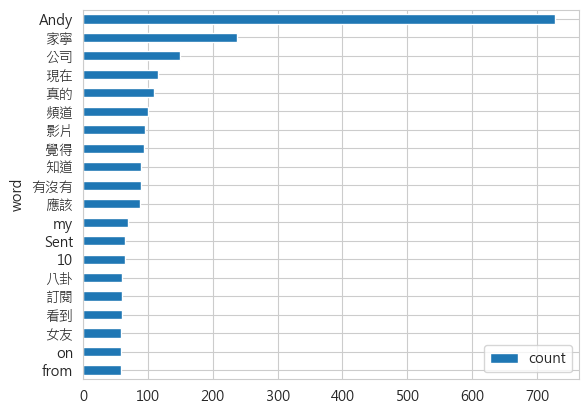

In [252]:
freq_df = pd.DataFrame(noStop_WC_A_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 1

In [255]:
stopwords_manual = ["家寧", "Andy", "公司", "現在", "影片", "真的", "知道", "應該", "有沒有", "my", "Sent", "10", "from", "覺得", "on", "看到", "八卦"]
stopwords.extend(stopwords_manual)

noStop_WC_A_df = word_WC_A_df[~word_WC_A_df['word'].isin(stopwords)]
noStop_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,太慘


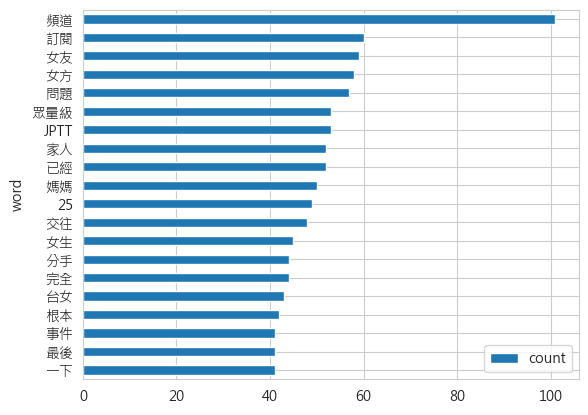

In [256]:
freq_df = pd.DataFrame(noStop_WC_A_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 2

In [257]:
stopwords_manual = ["女友", "女方", "問題", "JPTT", "家人", "眾量級", "媽媽", "25", "完全", "已經", "女生", "一下", "事件", "最後"]
stopwords.extend(stopwords_manual)

noStop_WC_A_df = word_WC_A_df[~word_WC_A_df['word'].isin(stopwords)]
noStop_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,太慘


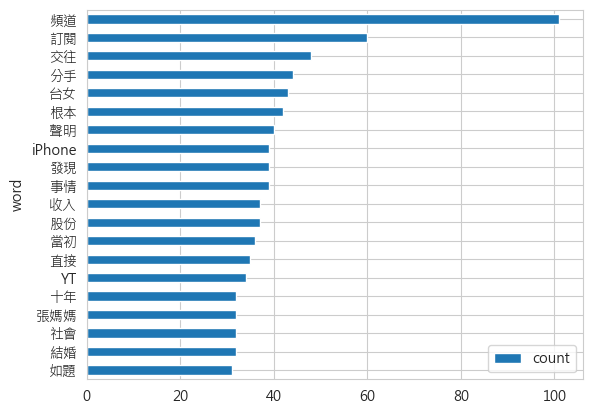

In [258]:
freq_df = pd.DataFrame(noStop_WC_A_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 3

In [259]:
stopwords_manual = ["iPhone", "發現", "事情", "當初", "直接", "YT", "張媽媽", "如題"]
stopwords.extend(stopwords_manual)

noStop_WC_A_df = word_WC_A_df[~word_WC_A_df['word'].isin(stopwords)]
noStop_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,太慘


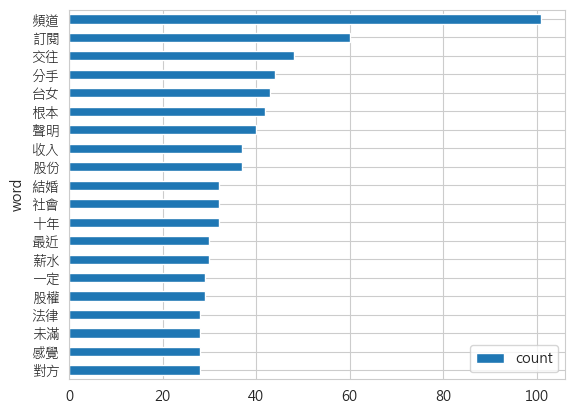

In [260]:
freq_df = pd.DataFrame(noStop_WC_A_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

移除停用字 - 4

In [261]:
stopwords_manual = ["十年", "一定", "感覺", "對方"]
stopwords.extend(stopwords_manual)

noStop_WC_A_df = word_WC_A_df[~word_WC_A_df['word'].isin(stopwords)]
noStop_WC_A_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,fromBePTTon
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,Samsung
0,https://www.ptt.cc/bbs/Gossiping/M.1741691316....,[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,https://youtu.be/kOZWQgtqps4?si=aCAxxZlpRorjzm...,SMS9260
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,看完
1,https://www.ptt.cc/bbs/Gossiping/M.1741692978....,Re:[問卦]眾量級andy說頻道錢都被家寧老母管？？,2025-03-11,剛看完 Andy太慘了\n不懂怎麼開公司 被女朋友媽媽騙\n然後只拿25%股權\n要看帳戶還...,太慘


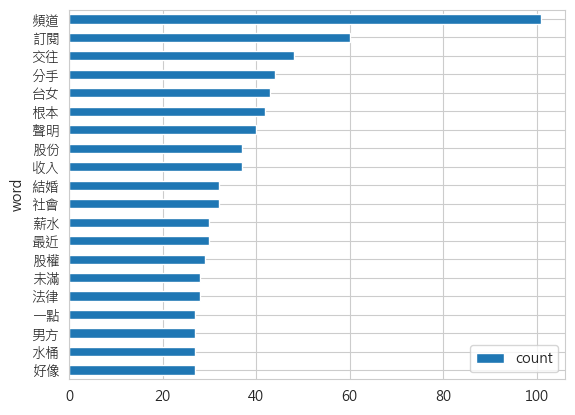

In [262]:
freq_df = pd.DataFrame(noStop_WC_A_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

### 文字雲

In [263]:
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']
print(dict(list(freq_dict.items())[:10]))

{'頻道': 101, '訂閱': 60, '交往': 48, '分手': 44, '台女': 43, '根本': 42, '聲明': 40, '股份': 37, '收入': 37, '結婚': 32}


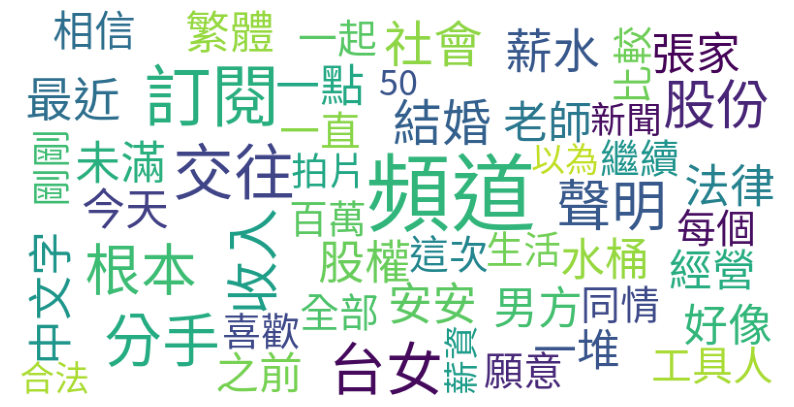

In [264]:
# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

查看提到水桶的文章

In [265]:
df_WC_A[df_WC_A["artContent"].str.contains("水桶", na=False, case=False)][["artTitle", "artDate", "artContent"]]

,artTitle,artDate,artContent
11,[問卦]南森真的要好好保護自己,2025-03-12,剛剛看完Andy的影片\n\n感覺就是被女人聯手陷害了阿\n\n家寧媽媽真的是高人耶\n\n...
171,[問卦]到底andy是誰家寧是誰啦,2025-03-13,大家好 我是誰誰獸\n\n到底Andy是誰 家寧是誰啦\n\n怎麼這幾天密集的有人發問\nh...
173,[問卦]只有我覺得Andy已經算爽了嗎?,2025-03-13,是否有專板\n本板並非萬能問板\n三則\n本看板嚴格禁止政治問卦\n未滿30繁體中文字水桶1...
207,[問卦]沙雕動畫會怎麼演Andy老師的故事,2025-03-14,我是一個百萬訂閱的youtuber\n卻發現跟我交往十年的女朋友是隻吸血蟲鬼\n開的公司被登...
213,[問卦]Andy是不是最佳套房代言人？,2025-03-14,Threads有人幫他算出抖內\n超過600萬了\n\n一週內翻身\n他所有分手後的題材都在...
304,[問卦]看到Andy訂閱數超過重量級大家有多感動,2025-03-15,是否有專板\n本板並非萬能問板\n三則\n本看板嚴格禁止政治問卦\n未滿30繁體中文字水桶1...
311,[問卦]大家這波都抖內多少給Andy老師,2025-03-15,是否有專板\n本板並非萬能問板\n三則\n本看板嚴格禁止政治問卦\n未滿30繁體中文字水桶1...
368,[問卦]Andy老師會回饋社會嗎,2025-03-18,是否有專板\n本板並非萬能問板\n三則\n本看板嚴格禁止政治問卦\n未滿30繁體中文字水桶1...
397,[問卦]Andy還是群海員工嗎？,2025-03-19,是否有專板\n本板並非萬能問板\n三則\n本看板嚴格禁止政治問卦\n未滿30繁體中文字水桶1...


In [266]:
id_bottle = [11, 171, 173, 207, 213, 304, 311, 368, 397]
for i in id_bottle:
    print(i)
    print(df_WC_A["artContent"][i])

11
剛剛看完Andy的影片

感覺就是被女人聯手陷害了阿

家寧媽媽真的是高人耶


ㄟ不過這劇情怎麼有點熟悉阿

好像少年賭神喔

Andy=高進

家寧=梁詠琪

家寧媽媽=梁詠琪爸爸

心靈成長集團=高傲

龍五=錫蘭


話說回來Andy應該超愛家寧的吧

才會那麼容易被利用

交往了十年居然連強制內射懷孕都辦不到

這到底是有多愛阿

信不信等等家寧說要復合Andy一定馬上說好啊各位
是否有專板
本板並非萬能問板
三則
本看板嚴格禁止政治問卦
未滿30繁體中文字水桶1個月
未滿20繁體中文字水桶2個月
未滿10繁體中文字水桶3個月，嚴重者以鬧板論
171
大家好 我是誰誰獸

到底Andy是誰 家寧是誰啦

怎麼這幾天密集的有人發問
https://i.imgur.com/2FWjCpz.jpg
要不是分手了 根本沒曝光度 過去也沒人在發廢問啊

然後現在新聞出來洗了一波

跟之前那個日本人妻一樣 出事前 who?

反觀在這個版名聲比較臭的九面或是墮特 椅子統神 IZSASA之類的 雖然不是百萬YTER(就九
面 IZSASA有啦) 但好歹三不五時有個版面

有沒有卦 484網軍想掩蓋什麼
https://i.imgur.com/vdoWlc3.jpg
附上老人有在訂閱的一小角 幾乎沒有百萬的
只有簡芝許伯
是否有專板
本板並非萬能問板
三則
本看板嚴格禁止政治問卦
未滿30繁體中文字水桶1個月
未滿20繁體中文字水桶2個月
未滿10繁體中文字水桶3個月，嚴重者以鬧板論
173
是否有專板
本板並非萬能問板
三則
本看板嚴格禁止政治問卦
未滿30繁體中文字水桶1個月
未滿20繁體中文字水桶2個月
未滿10繁體中文字水桶3個月，嚴重者以鬧板論
Andy 在YT也算是大主播

雖然收入上繳 但每個月還可以拿5.5萬

也就是說 每個月還有五萬多可以花

但是看竹科工程師 薪水 存摺 提款卡 信用卡

都上繳給女友或曖昧對象

每天只拿飲料錢50-100元 其他都吃公司餐不用花到錢


這樣看來 Andy哥 其實很爽了吧?

有八卦嗎?

也有人這樣覺得嗎
-
Sent from MeowPtt on my iPhone


207
我是一個百萬訂閱的youtuber
卻發現跟我交往十年的女朋友是隻吸血蟲鬼
開的公司被登記在女友媽媽名下
監察人是女友爸爸
身

"水桶"與本主題無關，屬於冗於資訊

查看提到結婚的文章

In [267]:
df_WC_A[df_WC_A["artContent"].str.contains("結婚", na=False, case=False)][["artTitle", "artDate", "artContent"]]

,artTitle,artDate,artContent
25,[問卦]ANDY行為跟結婚買房掛女方名下是不是很像,2025-03-12,台女從以前到現在其實都沒什麼變\n\n首先把AA制講得很難聽，來達到台女善用自身外表優勢滿足...
28,Re:[問卦]有人完全不同情ANDY的嗎?,2025-03-12,Andy這種做法\n不止不鼓勵\n\n其實收拾戰場的能力也不夠\n\n以前基於信任原則\n放...
38,[問卦]Andy是Gay嗎？,2025-03-12,我沒有冒犯的意思\n就是單純好奇\n\n因為我當初\n第一眼看到這對情侶\n就感覺很不般配啊...
45,[問卦]從Andy事件看成龍的愛情觀很超前時代?,2025-03-12,最近成龍的一段舊訪談又被翻出來，他說過：「我的生活以朋友、兄弟為主，女朋友沒什\n麼好說的。...
48,Re:[問卦]有沒有Andy老師八卦,2025-03-12,瞎猜\n交往久了，想結婚了\n但女方要求天價聘金\n這時才察覺不對勁\n我的錢都給你們了，以...
51,[問卦]Andy為啥跟家寧長跑十年沒結婚？,2025-03-12,剛看完Andy的影片\n\n滿可憐的\n\n以前偶爾會看他們的影片\n\n沒想到會是這種結局...
122,[問卦]難道andy一點錯都沒有嘛?,2025-03-13,難道Andy真的一點錯都沒有嘛?\n\n如題\n\n一定是Andy太投入在YT的世界裡 長期...
124,[問卦]欸欸，台男Andy現在算輸不起不甘心嗎？,2025-03-13,魯題~\n某個台男啦，這幾天很紅\n可是阿肥看了那些說詞齁\n關鍵都是他自己選的.........
127,[問卦]身邊多少跟Andy老師一樣遭遇的男人？,2025-03-13,最近眾量級Andy爆出被前女友家寧一家坑慘的新聞\n8年心血只拿25%股權，每月固定薪水幾萬...
134,[問卦]所以錢絕對不能交給女朋友對吧？,2025-03-13,統神把錢交給老婆管\n過得順風順水，基本上出事都是自己嘴巴惹出來的而已\n\n反觀Andy事...


In [269]:
id_marry = df_WC_A[df_WC_A["artContent"].str.contains("結婚", na=False, case=False)].index.tolist()
for i in id_marry:
    print(i)
    print(df_WC_A["artContent"][i])

25
台女從以前到現在其實都沒什麼變

首先把AA制講得很難聽，來達到台女善用自身外表優勢滿足自己不用付出$$$的目的

交往時，懂得善用男方戀愛腦時的台女優勢，達到勒索榨乾男方的任何資產

Andy把一切資產、名下權利、賺的錢都交給女方管理

行為跟傳統男方結婚買房，被女方要求
「房子要掛女方名下」
是不是很像？

若男方辦不到就會被女方情感勒索嫌說是否不夠愛女方？女方沒保障54321.....


Andy事件其實就是很多自私的台女縮影？！


28
Andy這種做法
不止不鼓勵

其實收拾戰場的能力也不夠

以前基於信任原則
放著不管理

拿少一些
那是因為疏於管理

其實要談結婚
就可以跟丈母娘提出
豪宴嫁粧

如果這點沒的談
那就還是分一分

止損點就在這裡

廣大的男生啊
有資產量要管理的

沒有資源的人才不用花太多的心力去釐清

這件事要看清楚
“管理”的重要

管太多不近人情
管太少，傷了自己

大家來看

八卦一則～～～
-
Sent from JPTT on my iPhone

38
我沒有冒犯的意思
就是單純好奇

因為我當初
第一眼看到這對情侶
就感覺很不般配啊==

加上
最近這些爆料
才知道
原來不能愛愛

這很奇怪吧
兩人合作
百萬級訂閱頻道

結果自己
領的錢跟社畜差不多
沒有結婚沒有名分
啥也不是
像個舔狗付出所有

我大概1個月都忍不了了

怎麼可能
有男人能夠忍那麼久==

如果我那麼紅
待遇那麼差又不能愛愛

那我會選擇加入反骨
瘋狂跟小咖網紅愛愛
一堆人排隊要跟我愛愛

加上
我覺得他的類型
跟黃氏兄弟其實滿像的

所以
有沒有一種可能？

其實Andy是Gay?
他們倆其實閨蜜？

閨蜜吵架翻臉
我覺得很合理

你們覺得呢？

45
最近成龍的一段舊訪談又被翻出來，他說過：「我的生活以朋友、兄弟為主，女朋友沒什
麼好說的。我不會浪費很多時間在女人身上。」還提到：「我看到周圍都在結婚、離婚，
那我不結婚了，很多女的一夜之間把老公的錢拿走，什麼都沒了。」這話聽起來超現實，
大哥這波操作是不是太精明了啊？

巧的是，最近百萬YouTuber情侶Andy和家寧鬧分手，Andy直接在影片爆料，說家寧的媽媽
掌控了公司股權，他自己只拿固定薪水，連帳目都看不到。分手後更慘，直接被斷經濟來
源，連頻道控制權都被奪走。這劇情也太誇張，跟成

大略內容概述：
1. 針對台女刻板印象的延伸討論
2. 對Andy行為的批判與反思
3. 對兩人關係、分手原因 (禮金談不合)進行討論
4. 台男狀況的延伸討論

## 比較

眾量級

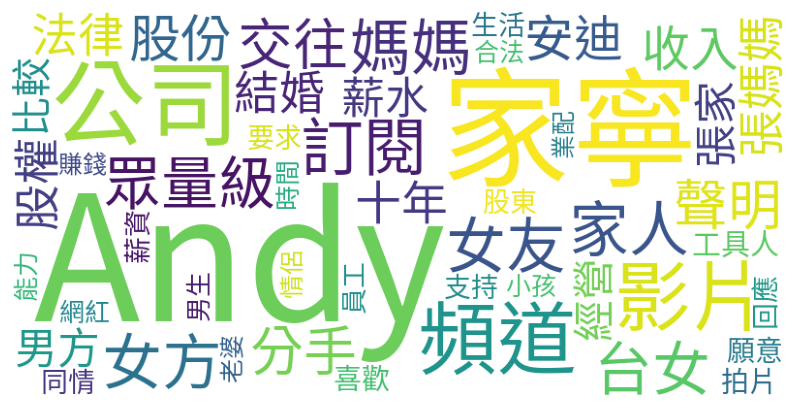

家寧

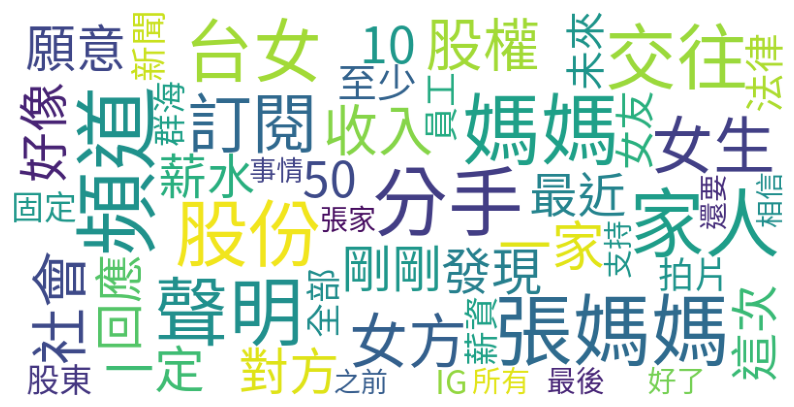

Andy

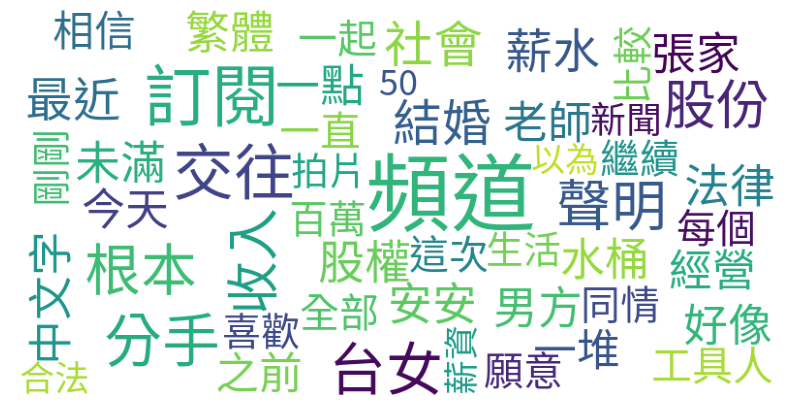